In [1]:
import pandas as pd
import numpy as np
import IPython.display as dispaly
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import xgboost as xgb
from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

from collections import Counter
from itertools import combinations
import math
from math import sqrt
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0" #comment out this line if you want to use gpu
import random
from keras.layers import Concatenate, Dense, Dot, Dropout, Embedding, Input, Reshape
from keras.models import Model
from keras.callbacks import Callback, ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow


import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBRegressor

pd.set_option('display.max_columns', 200)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import random
random.seed(2021)
np.random.seed(2021)
# tf > 2.0
tensorflow.random.set_seed(2021)
#tf < 2.0
#tf.set_random_seed(2021)

In [3]:
def rmse(pred, actual):
    # Ignore ratings with value zero.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))

In [4]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

# Import Data

In [5]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
valid_data = pd.read_csv('data/valid.csv')
business_data = pd.read_csv('data/business.csv')
user_data = pd.read_csv('data/user.csv')

business_data = business_data.drop(columns=['Unnamed: 0','address','city','state','postal_code',
                                            'latitude','longitude','hours'])

user_data = user_data.drop(columns=['Unnamed: 0','yelping_since'])

## User Data

In [6]:
user_data

,user_id,name,review_count,useful,funny,cool,elite,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,f04e1b175716b9ff46f0f58d14f65cbe,Karen,85,63,25,45,"2017,2018",4,4.40,1,0,0,0,0,1,3,1,1,3,0
1,9de9e40b3727c667a5b7c1664aa59a5b,Bobby,376,1754,1036,1124,"2013,2014,2015,2016,2017,2018",39,3.64,47,6,2,2,1,38,77,106,106,52,3
2,41a23c92933408a7fd98abed3d3d0071,Michele,244,435,76,145,NaN,23,4.38,6,5,0,1,0,4,13,13,13,9,6
3,1e8b87bf395e036ba5eff80e8b47d509,Christopher,267,1438,767,1157,"2013,2014,2015,2016,2017,2018",49,3.83,44,8,2,0,0,39,71,146,146,107,3
4,344c541cfca0e120924456e8c8cfd468,Lamiya,55,71,31,52,NaN,2,4.16,1,0,0,0,0,0,3,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2975,bf35ec4f129ed84d312ecbf271bb3351,Rebecca,56,23,2,19,NaN,7,4.32,0,0,1,0,0,1,1,0,0,0,0
2976,d2c81177bfb08e7209d714e711f5c4c3,Michael,63,140,59,28,NaN,1,2.70,0,1,0,0,0,5,1,0,0,0,0
2977,85339f5231ab001eb302ff2254fd29e5,Cynthia,54,22,9,6,NaN,1,3.33,0,0,0,0,0,0,0,0,0,0,0
2978,7eb178d152614644cf155a5dbae25bf8,Iso,30,19,7,3,NaN,0,2.47,0,1,0,0,0,0,0,0,0,0,0


In [7]:
list_for_elite = []
for i in range(len(user_data)):
    if user_data['elite'][i] != np.nan and type(user_data['elite'][i]) == str:
        list_for_elite.append(user_data['elite'][i].split(','))
    elif user_data['elite'][i] != np.nan and type(user_data['elite'][i]) == float:
        user_data['elite'][i] = str(user_data['elite'][i])
        list_for_elite.append(user_data['elite'][i].split(','))
    else:
        list_for_elite.append('NaN')

In [8]:
user_data['elite_year'] = list_for_elite
list_of_year = []
for x in user_data['elite_year']:
    for y in x:
        list_of_year.append(y)
list_of_year = list(set(list_of_year))            

In [9]:
for year in list_of_year:
    user_data['year'+year] = 0


for x in range(len(user_data)):
     for y in user_data['elite_year'][x]:
            for year in list_of_year:

                if y == year:
                    user_data['year'+year][x] = 1
                else:
                    user_data['year'+year][x] = 0
                
            

In [10]:
user_data = user_data.drop(columns=['elite','elite_year'])
user_data = user_data.drop(columns=['yearnan'])


## Business Data

In [11]:
all_categories = [category for category_list in business_data.categories.values for category in category_list.split(", ")]

# Sort all unique values of the item categories by their frequencies in descending order
category_sorted = sorted(Counter(all_categories).items(), key=lambda x: x[1], reverse=True)

# Select categories with frequency more than 100
selected_categories = [t[0] for t in category_sorted if t[1]>=100]

In [12]:
from tqdm import trange
for category in selected_categories:
    business_data[category] = 0


for x in trange(len(business_data)):
    for y  in business_data['categories'][x].split(", "):
         for category in selected_categories:

                if y == category:
                    business_data[category][x] = 1
                else:
                    business_data[category][x] = 0
                
            

100%|██████████████████████████████████████████████████████████████████████████████| 5964/5964 [01:27<00:00, 68.36it/s]


In [13]:
business_data = business_data.drop(columns=['attributes','categories'])

# Marge Datasets

In [14]:
train = pd.merge(
    train_data,
    user_data,
    how="left",
    on="user_id"
)

train = pd.merge(
    train,
    business_data,
    how="left",
    on="business_id"
)

In [15]:
train = train.drop(columns=['name_x','name_y'])
train['stars'] = train['stars_x']
train = train.drop(columns=['stars_x'])
train['review_count_user'] = train['review_count_x']
train['review_count_business'] = train['review_count_y']
train = train.drop(columns=['review_count_x','review_count_y'])
train['stars_business'] = train['stars_y']
train = train.drop(columns=['stars_y'])
train['stars_users'] = train['stars']
train = train.drop(columns=['stars'])
train

,user_id,business_id,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,year2011,year2017,year2013,year2009,year2015,year2014,year2016,year2010,year2018,year2007,year2012,year2006,year2008,is_open,Restaurants,Food,Nightlife,Bars,American (New),American (Traditional),Breakfast & Brunch,Sandwiches,Italian,Mexican,Event Planning & Services,Seafood,Pizza,Burgers,Japanese,Arts & Entertainment,Sushi Bars,Coffee & Tea,Desserts,Salad,Asian Fusion,Steakhouses,Chinese,Hotels & Travel,Cocktail Bars,Cafes,Beer,Wine & Spirits,Vegetarian,Wine Bars,Barbeque,Sports Bars,Bakeries,Specialty Food,Mediterranean,Lounges,Thai,Beauty & Spas,Pubs,Hotels,Vegan,Diners,Caterers,Shopping,Automotive,Gluten-Free,Active Life,Venues & Event Spaces,Fast Food,Gastropubs,French,Juice Bars & Smoothies,Buffets,Korean,Chicken Wings,Ice Cream & Frozen Yogurt,Casinos,Vietnamese,Auto Repair,Greek,review_count_user,review_count_business,stars_business,stars_users
0,11d83531dcee4af6f5701696ff45a8d8,54eb8c224740ce5a8a1db56324cbf0c0,150,83,56,2,3.25,0,0,0,0,0,4,5,2,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,75,441,4.0,3.0
1,f3270a0bfa9f67f4b00fd9dadbf1d3e4,e398e51ecca29473c80b058ab17e903e,1713,466,1155,73,4.58,26,3,1,0,0,11,47,67,67,21,30,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,430,343,4.0,5.0
2,8515478d756cecae1d46ad274e583fba,62d5a2614594cdfe014cb3f47bc1f183,186,50,98,16,4.03,12,1,0,0,0,7,15,6,6,9,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,66,450,3.5,4.0
3,f7a8d4e39387479bee5786d9af7a384e,5e4ad90afb13df5004803bd165a905a9,363,145,223,9,3.88,2,0,1,1,0,4,10,10,10,6,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,247,401,4.0,5.0
4,edbc6b267c51aaa5f89ec35237126649,cff931388a0021c662fa8d3437448a89,53,11,17,0,3.68,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,113,473,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60075,34dea4ede612fd05bd8431c597204b3d,1f3f068cd8717298ed51314cc0d47a77,118,32,67,6,3.77,1,5,2,0,0,2,2,8,8,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,128,566,3.0,3.0
60076,aa24183e54f6657ab3545557271bdc2a,670b348d2a411ec96a1e45c4764192dc,330,127,160,22,4.09,11,6,1,3,2,5,24,11,11,10,6,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,434,897,3.0,2.0
60077,b695bc3cf274961ccba9ab4d2bfaddb8,9e4b3792e6281bc37abfbc4c9eeb05eb,221,69,77,17,3.70,3,1,0,2,0,10,41,4,4,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,221,207,3.5,4.0
60078,d6b815c6e6775df6bb61ea513e78fd52,c14d09d594c535aa5bd06ca537b9b19e,1226,391,449,43,3.33,15,4,2,0,1,38,32,27,27,20,5,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1146,206,3.0,2.0


## Model Training

In [16]:
x_train = train.drop(columns=['stars_users','user_id', 'business_id'])
y_train = train['stars_users']

In [17]:
!nvidia-smi

Mon May 17 09:54:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 442.62       Driver Version: 442.62       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce MX250      WDDM  | 00000000:02:00.0 Off |                  N/A |
| N/A   56C    P8    N/A /  N/A |    934MiB /  2048MiB |     14%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Randomsearch fro best parameters

In [22]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.02, 0.05],
        'n_estimators': [200,400,600,800,1000],
        'learning_rate': [0.01, 0.02, 0.05]   
        }

In [23]:
%%time 
folds = 5
param_comb = 300


X = x_train
Y = y_train

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

xgb = XGBRegressor(tree_method='gpu_hist', eval_metric='rmse')

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, n_jobs=-1, cv=skf.split(X,Y), verbose=100, random_state=1001, scoring="neg_mean_squared_error")

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X, Y)
timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 300 candidates, totalling 1500 fits

 Time taken: 2 hours 12 minutes and 11.42 seconds.
CPU times: user 17 s, sys: 2.29 s, total: 19.3 s
Wall time: 2h 12min 11s


In [24]:
random_search.best_params_

{'subsample': 0.6,
 'n_estimators': 1000,
 'min_child_weight': 10,
 'max_depth': 3,
 'learning_rate': 0.02,
 'gamma': 0.5,
 'colsample_bytree': 0.6}

In [25]:
random_search.best_score_

-1.0043248782616925

In [26]:
random_search.best_estimator_.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.6,
 'gamma': 0.5,
 'gpu_id': 0,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.02,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 10,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 1000,
 'n_jobs': 2,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.6,
 'tree_method': 'gpu_hist',
 'validate_parameters': 1,
 'verbosity': None,
 'eval_metric': 'rmse'}

## Model Testing

In [18]:
X = x_train
Y = y_train

In [19]:
gbm = XGBRegressor(base_score= 0.5, booster= 'gbtree', colsample_bylevel= 1, colsample_bynode= 1,
colsample_bytree= 0.6, eval_metric= 'rmse', gamma= 0.5,  importance_type = 'gain',  learning_rate =0.02,
max_delta_step = 0, max_depth = 5, min_child_weight = 5, missing = np.nan, n_estimators = 1000,
n_jobs =  2, nthread = None, objective = 'reg:squarederror', random_state = 0, reg_alpha = 0,
reg_lambda = 1, scale_pos_weight = 1, seed = None, silent = None, subsample = 0.6,
 tree_method = 'gpu_hist',  verbosity = 1).fit(X, Y)

In [20]:
valid = pd.merge(
    valid_data,
    user_data,
    how="left",
    on="user_id"
)

valid = pd.merge(
    valid,
    business_data,
    how="left",
    on="business_id"
)

valid = valid.drop(columns=['name_x','name_y'])
valid['review_count_user'] = valid['review_count_x']
valid['review_count_business'] = valid['review_count_y']
valid = valid.drop(columns=['review_count_x','review_count_y'])
valid['stars_business'] = valid['stars_y']
valid = valid.drop(columns=['stars_y'])
valid['stars_users'] = valid['stars_x']
valid = valid.drop(columns=['stars_x'])
valid

x_valid = valid.drop(columns=['stars_users','user_id', 'business_id'])
y_valid = valid['stars_users']

## Prediction on train set

In [21]:
predictions = gbm.predict(X)

In [22]:
rmse(np.array(predictions.tolist()),np.array(Y.tolist()))

0.9636991876357113

## Prediction on valid set

In [23]:
predictions = gbm.predict(x_valid)

In [24]:
rmse(np.array(predictions.tolist()),np.array(y_valid.tolist()))

0.9892214476922436

## Residue analysis

In [25]:
error = y_valid- predictions

In [26]:
max(error), min(error)

(3.385107398033142, -3.7810187339782715)

Text(0, 0.5, 'Frequency')

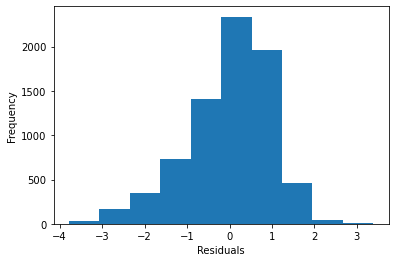

In [27]:
plt.hist(error)
plt.show
plt.xlabel('Residuals')
plt.ylabel('Frequency')

## Test

In [28]:
test = pd.merge(
    test_data,
    user_data,
    how="left",
    on="user_id"
)

test = pd.merge(
    test,
    business_data,
    how="left",
    on="business_id"
)

test = test.drop(columns=['name_x','name_y'])
test['review_count_user'] = test['review_count_x']
test['review_count_business'] = test['review_count_y']
test = test.drop(columns=['review_count_x','review_count_y'])
test['stars_business'] = test['stars_y']
test = test.drop(columns=['stars_y'])
test['stars_users'] = test['stars_x']
test = test.drop(columns=['stars_x'])
test

x_test = test.drop(columns=['stars_users','user_id', 'business_id'])

In [29]:
predictions = gbm.predict(x_test)

In [30]:
test['stars']= predictions
test = test[['user_id', 'business_id', 'stars']]

In [31]:
test.to_csv('test.csv')